Data Preprocessing:

1.This step will focus on extracting data from SQL databases, cleaning it, and preparing it for machine learning.
#Example Code (Python + SQLAlchemy for database connection):


In [1]:
import pandas as pd
from sqlalchemy import create_engine
from scipy.stats import zscore


# Load Excel file
df = pd.read_excel("C:/Users/darshan gangappa/Downloads/Cleaned_Data_Set_with_Target.xlsx")

# Create a local SQLite database in memory (no account needed)
engine = create_engine('sqlite:///:memory:')

# Save the DataFrame to a SQL table
df.to_sql('my_table', con=engine, index=False, if_exists='replace')

# Now you can run SQL queries using pandas
result = pd.read_sql('SELECT * FROM my_table LIMIT 5', con=engine)
#print(result)

df.fillna(df.mean(), inplace=True)

df = df[(zscore(df.select_dtypes(include=['float64', 'int64'])) < 3).all(axis=1)]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[df.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(df.select_dtypes(include=['float64', 'int64']))


print(df.head())

         ID       Age    Salary  PurchaseAmount PurchaseDate  target
0  0.000000  0.605263  0.666667        0.307094   2025-03-21     0.0
1  0.020408  0.315789  0.274510        0.641986   2025-06-17     0.0
2  0.040816  0.947368  0.352941        0.191691   2025-07-10     0.0
3  0.061224  0.184211  0.019608        0.515026   2025-01-29     0.0
4  0.081633  0.789474  0.486859        0.000000   2025-02-15     0.0


2. Supervised Learning Model for Anomaly Detection:

The code establishes a supervised anomaly detection framework by introducing synthetic anomalies into the dataset. It randomly selects a portion of normal records and inflates their PurchaseAmount to simulate anomalous behavior, labeling these instances as anomalies (with a target value of 1). This approach creates a dataset that contains both normal and anomalous samples, allowing for the application of supervised learning techniques.

Next, the data is split into training and testing sets using stratified sampling, which helps maintain the class distribution. A Decision Tree Classifier is then trained on the training data to identify patterns that differentiate anomalies from normal transactions. Finally, the model's predictions on the test set are evaluated using metrics such as precision, recall, and F1-score, providing insights into its effectiveness in detecting anomalies.

In [3]:
import pandas as pd
import numpy as np

df['target'] = 0  # Start with all normal

num_anomalies = int(0.2 * len(df))  # 20% anomalies (you can adjust this)
anomalies = df.sample(n=num_anomalies, random_state=42).copy()

anomalies['PurchaseAmount'] = anomalies['PurchaseAmount'] * 10  # Make this feature extreme
anomalies['target'] = 1

# Step 3: Combine back
df = pd.concat([df, anomalies], ignore_index=True)

# Now check target distribution
print(df['target'].value_counts())

target
0    45
1     9
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import OneClassSVM

X = df.drop(columns=['target', 'PurchaseDate'])
y = df['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[14  0]
 [ 1  2]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.67      0.80         3

    accuracy                           0.94        17
   macro avg       0.97      0.83      0.88        17
weighted avg       0.95      0.94      0.94        17



In [7]:
from sklearn.metrics import accuracy_score

# Accuracy on training data
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Accuracy on test data
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


Train Accuracy: 0.972972972972973
Test Accuracy: 0.9411764705882353


3.Unsupervised Learning for Anomaly Detection (Clustering):
#If we don't have labels for anomalies, we can use unsupervised learning models like KMeans or DBSCAN.
#Example Code (Clustering with DBSCAN for anomaly detection):


In [9]:
from sklearn.cluster import DBSCAN
import numpy as np

# Assume that the data has already been preprocessed and scaled
X = df.select_dtypes(include=['float64', 'int64'])

# DBSCAN Clustering (Unsupervised)
db = DBSCAN(eps=0.5, min_samples=5)
y_db = db.fit_predict(X)

# DBSCAN labels -1 as anomalies
df['dbscan_anomaly'] = y_db

# Display detected anomalies
print(df[df['dbscan_anomaly'] == -1])


          ID       Age    Salary  PurchaseAmount PurchaseDate  target  \
45  0.897959  0.473684  0.372549        5.149107   2025-04-26       1   
46  0.612245  0.131579  0.137255        5.149107   2025-01-30       1   
47  0.632653  0.289474  0.470588        4.687117   2025-02-25       1   
48  0.979592  0.315789  0.411765        6.304082   2025-06-06       1   
49  0.816327  0.447368  0.647059        8.383036   2025-05-13       1   
50  0.938776  0.078947  0.215686        3.532143   2025-01-17       1   
51  0.081633  0.789474  0.486859        0.000000   2025-02-15       1   
52  0.285714  0.868421  0.411765        5.381488   2025-02-02       1   
53  0.183673  0.157895  0.156863        2.031138   2025-01-18       1   

    dbscan_anomaly  
45              -1  
46              -1  
47              -1  
48              -1  
49              -1  
50              -1  
51              -1  
52              -1  
53              -1  


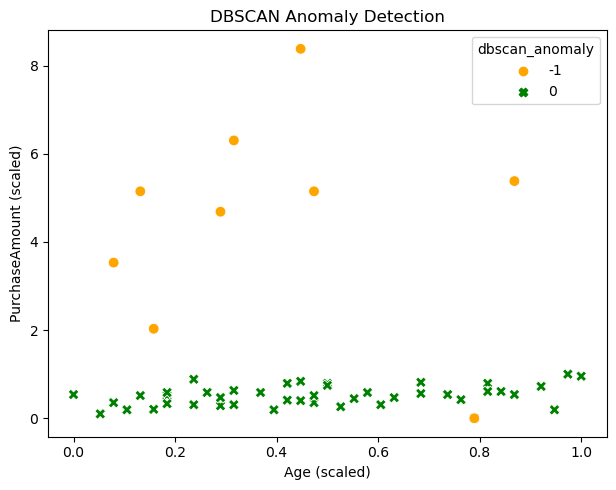

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
sns.scatterplot(
    data=df,
    x='Age',
    y='PurchaseAmount',
    hue='dbscan_anomaly',
    palette={0: 'green', -1: 'orange'},
    style='dbscan_anomaly',
    s=60
)
plt.title('DBSCAN Anomaly Detection')
plt.xlabel('Age (scaled)')
plt.ylabel('PurchaseAmount (scaled)')

plt.tight_layout()
plt.show()


#4.Integration into SQL Database (In-Database Machine Learning):
#Now, we will explore how to integrate machine learning models directly into SQL databases using in-database machine learning techniques. This is platform-dependent (e.g., PostgreSQL, Microsoft SQL Server, Oracle). Below is an example for SQL Server using SQL queries for predictive scoring.
#Example Code (SQL Server + In-database ML using SQL queries):

In [13]:
import pyodbc
import pandas as pd

conn = pyodbc.connect(
    "DRIVER={ODBC Driver 18 for SQL Server};"
    "SERVER=DELL-LAPTOP;"
    "DATABASE=Salary;"
    "Trusted_Connection=yes;"
    "Encrypt=no;"
)

# Query data from SQL Server
df = pd.read_sql("SELECT * FROM dbo.Dataset_salary", conn)
conn.close()

print(df.head())


   ID  Age   Salary  PurchaseAmount PurchaseDate  target
0   1   45  98000.0     2000.339966   2025-03-21   False
1   2   34  78000.0     3450.120117   2025-06-17   False
2   3   58  82000.0     1500.750000   2025-07-10   False
3   4   29  65000.0     2900.500000   2025-01-29   False
4   5   52      NaN      670.900024   2025-02-15   False


C:\Users\darshan gangappa\AppData\Local\Temp\ipykernel_18488\2750633296.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM dbo.Dataset_salary", conn)


5.This code implements an anomaly detection system using a Bidirectional LSTM neural network built with TensorFlow/Keras. The dataset undergoes essential preprocessing, including handling missing values for numerical columns like Salary and PurchaseAmount, extracting time-based features from the PurchaseDate, and scaling all features using StandardScaler for stable model training. The data is reshaped into a 3D format suitable for LSTM input with dimensions (samples, time_steps, features). A proper train-test split ensures that the model is evaluated on unseen data, preserving the integrity of the anomaly detection task.

The deep learning model consists of stacked Bidirectional LSTM layers that capture both forward and backward temporal dependencies in the data, followed by dropout layers to reduce overfitting and a dense layer with a sigmoid activation function for binary classification (anomaly or normal). The model is compiled using binary cross-entropy loss, the Adam optimizer, and accuracy as the performance metric. To handle class imbalance, class weights are computed to penalize the model more for misclassifying rare anomalies. The model is trained with early stopping based on validation loss to prevent overfitting, and its predictions are evaluated on the test set.

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


# Fill missing values (mean strategy)
df['Salary'].fillna(df['Salary'].mean(), inplace=True)
df['PurchaseAmount'].fillna(df['PurchaseAmount'].mean(), inplace=True)


df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'], errors='coerce')
df['PurchaseYear'] = df['PurchaseDate'].dt.year
df['PurchaseMonth'] = df['PurchaseDate'].dt.month
df['PurchaseDay'] = df['PurchaseDate'].dt.day
df['PurchaseDayOfWeek'] = df['PurchaseDate'].dt.dayofweek

X = df.drop(columns=['target', 'PurchaseDate'])
y = df['target'].astype(int)  # Ensure target is binary 0/1

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for LSTM 
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])


X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)



model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True)))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary output

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

y_train_array = y_train.to_numpy()

class_labels = np.unique(y_train_array)
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train_array)
class_weights = dict(zip(class_labels, weights))

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train_array, 
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    callbacks=[early_stop],
    class_weight=class_weights
)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.3542 - loss: 0.7798 - val_accuracy: 0.6250 - val_loss: 0.6924
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.2917 - loss: 0.7761 - val_accuracy: 0.7500 - val_loss: 0.6913
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.2708 - loss: 0.7044 - val_accuracy: 0.8750 - val_loss: 0.6901
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.4583 - loss: 0.7020 - val_accuracy: 0.7500 - val_loss: 0.6889
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.4792 - loss: 0.7700 - val_accuracy: 0.7500 - val_loss: 0.6877
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.4375 - loss: 0.7674 - val_accuracy: 0.7500 - val_loss: 0.6865
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5208 - loss: 0.7575 - val_accuracy: 0.7500 - val_loss: 0.6853
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4375 - loss: 0.8226 - val_accuracy: 0.7500 - val_loss: 0

In [19]:
test_predictions = model.predict(X_test)
predicted_labels = (test_predictions > 0.5).astype(int).flatten()

# Print detected anomalies
print("\nDetected anomalies on test data (1 = anomaly, 0 = normal):")
print(predicted_labels)

# Optional: View test accuracy
from sklearn.metrics import accuracy_score, classification_report

print("\nTest Accuracy:", accuracy_score(y_test, predicted_labels))
print("\nClassification Report:\n", classification_report(y_test, predicted_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Detected anomalies on test data (1 = anomaly, 0 = normal):
[0 1 0 1 0 1 0 1 1 0]

Test Accuracy: 0.6

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.20      1.00      0.33         1

    accuracy                           0.60        10
   macro avg       0.60      0.78      0.52        10
weighted avg       0.92      0.60      0.68        10



6.The visualization section provides clear insights into the model's performance over time. It plots both training and validation loss curves to help assess model convergence and overfitting. Similarly, training and validation accuracy curves illustrate learning progression, with a red dashed line overlay showing the final test accuracy for direct comparison. These plots help determine whether the model is generalizing well or if it's overfitting to the training data. By visualizing loss and accuracy trends together with test performance, this approach ensures transparency and interpretability in the anomaly detection pipeline.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


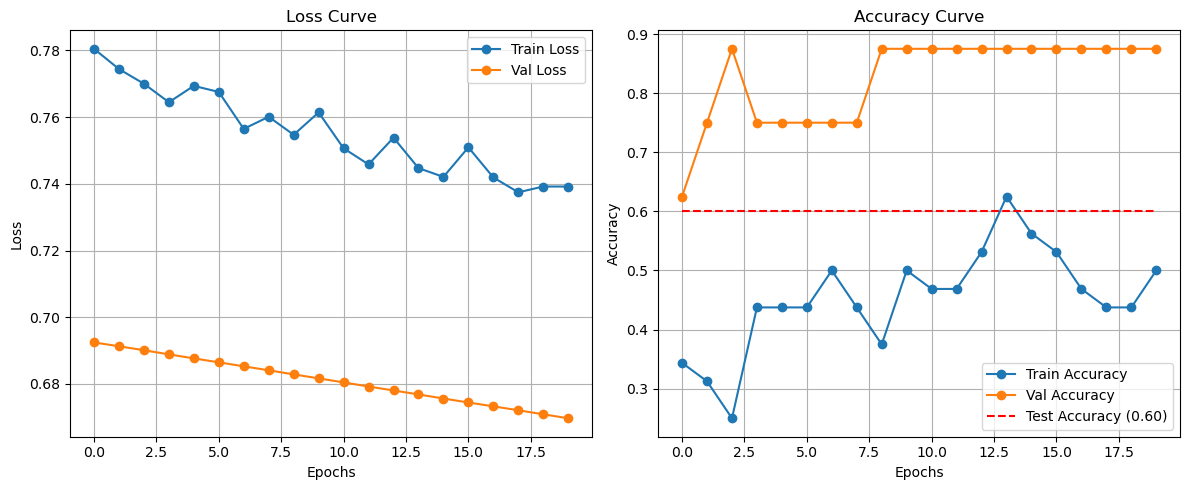

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Calculate test accuracy
test_predictions = model.predict(X_test)
predicted_labels = (test_predictions > 0.5).astype(int).flatten()
test_acc = accuracy_score(y_test, predicted_labels)

# Plot
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.hlines(test_acc, xmin=0, xmax=len(history.history['accuracy']) - 1, colors='r', linestyles='dashed', label=f'Test Accuracy ({test_acc:.2f})')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
